# Hybrid Auto and AStar

Creates 3 transmon pockets in an L shape, each of which can be rotated in increments of 90 deg.
Anchors are user-specified points through which the CPW must pass.
For a specified step size and suitable choice of anchors, a snapped path can always be found.
How close this path is to the shortest path depends on the step size - a smaller step size generally yields more optimal paths but requires a longer runtime.

## Preparations

The next cell enables [module automatic reload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload). Your notebook will be able to pick up code updates made to the qiskit-metal (or other) module code.

In [1]:
%load_ext autoreload
%autoreload 2

Import key libraries and open the Metal GUI. Also we configure the notebook to enable overwriting of existing components

In [2]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict

design = designs.DesignPlanar()
gui = MetalGUI(design)

# If you disable the next line, then you will need to delete a component [<component>.delete()] before recreating it.
design.overwrite_enabled = True

Create 3 transmon qubits with 4 pins. This uses the same definition (options) for all 3 qubits, but it places them in 3 different (x,y) origin points.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

options = dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(  # pin connectors
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        d = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

q0 = TransmonPocket(design, 'Q0', options = dict(pos_x='-1.0mm', pos_y='-1.0mm', **options))
q1 = TransmonPocket(design, 'Q1', options = dict(pos_x='1.0mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(pos_x='-1.0mm', pos_y='0.0mm', **options))

gui.rebuild()
gui.autoscale()

Import the RoutePathfinder class and inspect what options are available for you to initialize.

In [4]:
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
RoutePathfinder.get_template_options(design)

{'pin_inputs': {'start_pin': {'component': '', 'pin': ''},
  'end_pin': {'component': '', 'pin': ''}},
 'fillet': '0',
 'lead': {'start_straight': '0mm',
  'end_straight': '0mm',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '7mm',
 'chip': 'main',
 'layer': '1',
 'trace_width': 'cpw_width',
 'anchors': {},
 'advanced': {'avoid_collision': 'true'},
 'step_size': '0.25mm',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False}

Here we've set the fillet radius to be 90 microns.

In [5]:
ops=dict(fillet='90um')

Using the 3-qubit arrangement from before, our goal is to connect pins on two of them. Moreover, we want some degree of control over how that path is constructed.
This is where anchors come into play. Anchors are predefined points in space that the path must cross. They are stored in an ordered dictionary data structure that maps the
anchor number to a numpy array of length 2. The anchor number is an integer, starting at 0, that determines that anchor point's position relative to the start pin; larger
anchor numbers are farther along the path. The numpy array stores the x and y coordinates of the anchor.

For this and the subsequent examples, we have chosen a step size of 0.25 mm, which means that the algorithm searches for valid paths to the next anchor point in increments
of that amount. Valid paths do not collide with other components or self-intersect. The start and end pins are labelled by their component and component-specific pin, in
this case Q0_b and Q1_b.

In [6]:
import numpy as np
from collections import OrderedDict

anchors = OrderedDict()
anchors[0] = np.array([0.048, -0.555])
anchors[1] = np.array([0.048, 0.195])

options = {'pin_inputs': 
            {'start_pin': {'component': 'Q0', 'pin': 'b'}, 
             'end_pin': {'component': 'Q1', 'pin': 'b'}},
            'lead': {'start_straight': '91um', 'end_straight': '90um'},
            'step_size': '0.25mm',
            'anchors': anchors,
            **ops
           }

qa = RoutePathfinder(design, 'line', options)

gui.rebuild()
gui.autoscale()

The current algorithm can only allow 1 such CPW to be built at a time, thus we delete old CPWs before building new ones.

In [7]:
design.delete_component('line')

gui.rebuild()

Now let's try wrapping the CPW around the outer edge of the bottom left qubit.

In [8]:
anchors = OrderedDict()
anchors[0] = np.array([-0.452, -0.555])
anchors[1] = np.array([-0.452, -1.5])
anchors[2] = np.array([0.048, -1.5])

options = {'pin_inputs': 
            {'start_pin': {'component': 'Q0', 'pin': 'b'}, 
             'end_pin': {'component': 'Q1', 'pin': 'b'}},
            'lead': {'start_straight': '91um', 'end_straight': '90um'},
            'step_size': '0.25mm',
            'anchors': anchors,
            **ops
           }

qa = RoutePathfinder(design, 'line', options)

gui.rebuild()
gui.autoscale()

In [9]:
design.delete_component('line')

gui.rebuild()

We can also try switching around the components/pins and not specifying any anchor points to see what happens.

In [10]:
options = {'pin_inputs': 
            {'start_pin': {'component': 'Q0', 'pin': 'a'}, 
             'end_pin': {'component': 'Q2', 'pin': 'd'}},
            'lead': {'start_straight': '90um', 'end_straight': '90um'},
            'step_size': '0.25mm',
            **ops
          }

qa = RoutePathfinder(design, 'line', options)

gui.rebuild()
gui.autoscale()

In [11]:
design.delete_component('line')

gui.rebuild()

Or we can specify even more anchor points!

In [12]:
anchors = OrderedDict()
anchors[0] = np.array([-2, 0.5])
anchors[1] = np.array([0, 0.5])
anchors[2] = np.array([0, -1])
anchors[3] = np.array([2, -1])

options = {'pin_inputs': 
            {'start_pin': {'component': 'Q0', 'pin': 'd'}, 
             'end_pin': {'component': 'Q1', 'pin': 'c'}},
            'step_size': '0.25mm',
            'anchors': anchors,
            **ops
           }

qc = RoutePathfinder(design, 'line', options)

gui.rebuild()
gui.autoscale()

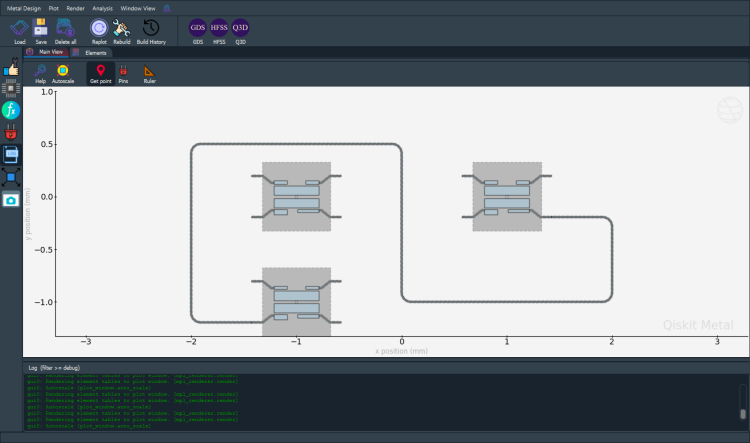

In [13]:
gui.screenshot()

TODOs:

1. CPW bounding boxes are not well-defined and cannot overlap right now. Bounding boxes should occupy as little
area as possible to maximize space for other components.
    Example: Connecting Q0_a and Q1_b ought to yield an S-shaped CPW but doesn't because there's supposedly a
    bounding box with 0 area centered at the origin (0, 0).
2. Rebuilding distorts previously well-defined CPWs.
    Example: Connect Q0_a, Q1_c, then connect Q1_b and Q0_d.
3. Enable anchor revision via the GUI.
4. Save a persistent state in the design so that rebuilding doesn't waste time.